In [34]:
IMAGE_SIZE = (224, 224)
image_dir = "images"

In [35]:
import yfinance as yf

def get_stock_data(stock_symbol, start_date, end_date):
    ticker = yf.Ticker(stock_symbol)
    df = ticker.history(start=start_date, end=end_date, interval='1d', auto_adjust=False)
    df.index = df.index.date

    return df[['Open', 'High', 'Low', 'Close']]

In [36]:
import mplfinance as mpf
import os

def save_ohlc_charts(df, stock_symbol, 
                     image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), 
                     window_size=20, 
                     show_info=True):
    if not os.path.exists('images'):
        os.makedirs('images')

    last_dates = []  # 마지막 날짜를 저장할 리스트

    for i in range(len(df) - window_size):
        windowed_df = df.iloc[i:i + window_size]
        last_date = windowed_df.index[-1]  # 마지막 날짜 추출
        last_dates.append(last_date)

        title = f"{stock_symbol} OHLC Chart" if show_info else ""
        if (show_info):
            fig, ax = mpf.plot(windowed_df, type='candle', style='charles', 
                               title=title, 
                               returnfig=True)
        else:
            fig, ax = mpf.plot(windowed_df, type='candle', style='charles', 
                               title=title, returnfig=True)
            # 모든 축, 눈금, 라벨 제거
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[0].set_xlabel('')
            ax[0].set_ylabel('')
            ax[0].xaxis.label.set_visible(False)
            ax[0].yaxis.label.set_visible(False)

            # 축 제거
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)
            ax[0].spines['left'].set_visible(False)

            # 그리드 제거
            ax[0].grid(False)
            
        fig.set_size_inches(image_size[0] / fig.dpi, image_size[1] / fig.dpi)
        image_path = f'images/{stock_symbol}_{i}.png'
        fig.savefig(image_path)
        plt.close(fig)

    return last_dates



In [37]:
def label_data(df, window_size=20):
    labels = []
    for i in range(window_size, len(df)):
        today = df.iloc[i - 1]['Close']
        tomorrow = df.iloc[i]['Close']
        label = 1 if tomorrow > today else 0
        labels.append(label)
    return labels

In [38]:

import pandas as pd
import matplotlib.pyplot as plt

def save_labels(labels, filename):
    df = pd.DataFrame(labels, columns=['label'])
    df.to_csv(filename, index=False)

def load_labels(filename):
    df = pd.read_csv(filename)
    return df['label'].tolist()

In [39]:
import pandas as pd

stock_symbol = 'AAPL'
start_date = '1990-01-01'
end_date = '2021-12-31'

# 데이터 불러오기
df = get_stock_data(stock_symbol, start_date, end_date)

# 함수 사용 예시
last_dates = save_ohlc_charts(df, stock_symbol, show_info=False)

# 라벨 생성
labels = label_data(df)

# DataFrame 생성
data = {'last_date': last_dates, 'label': labels}
chart_df = pd.DataFrame(data)

# CSV 파일로 저장
chart_df.to_csv('chart_data.csv', index=False)

# # CSV 파일에서 DataFrame 로드
# chart_df = pd.read_csv('chart_data.csv')
#
# # 'last_date' 컬럼을 리스트로 변환
# last_date_list = loaded_df['last_date'].tolist()
#
# # 'label' 컬럼을 리스트로 변환
# label_list = loaded_df['label'].tolist()

#유사이미지 찾기

In [40]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

In [41]:
def extract_features(img_path, model):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

# VGG16 모델 로드 (마지막 분류 레이어 제외)
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.input, outputs=model.output)

In [42]:
def create_feature_dataset(image_dir, model):
    feature_list = []
    image_files = [x for x in os.listdir(image_dir) if x.endswith('.png')]
    image_files.sort()  # 파일 이름 순서대로 정렬

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        features = extract_features(img_path, model)
        feature_list.append(features)

    return feature_list, image_files

image_dir = 'images'
feature_list, image_files = create_feature_dataset(image_dir, model)



1/1 [==============================] - 0s 11ms/step


In [43]:
import numpy as np

# feature_list를 넘파이 배열로 변환 후 저장
feature_array = np.array(feature_list)
np.save('feature_list.npy', feature_array)

import pickle

# image_files 리스트를 pickle 형식으로 저장
with open('image_files.pkl', 'wb') as f:
    pickle.dump(image_files, f)

In [45]:
def find_similar_images(query_img_path, feature_list, image_files, model, top_n=5):
    query_features = extract_features(query_img_path, model)
    similarities = cosine_similarity([query_features], feature_list)
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]

    return [(image_files[i], i) for i in similar_indices]

# 쿼리 이미지 경로
query_img_path = 'images/AAPL_8042.png'

# 유사한 이미지 찾기
similar_images = find_similar_images(query_img_path, feature_list, image_files, model)

1/1 [==============================] - 0s 15ms/step


In [46]:
#labels = [...]  # 이미지 파일 순서와 동일한 라벨 데이터

#similar_images_with_labels = [(img, idx, labels[idx]) for img, idx in similar_images]

In [31]:
#type(similar_images[i][1])
#plt.imshow(similar_images[i])
#len(similar_images)
print(similar_images)

[('AAPL_8042.png', 7827), ('AAPL_8041.png', 7826), ('AAPL_8040.png', 7825), ('AAPL_8039.png', 7823), ('AAPL_2088.png', 1211)]


In [77]:
def get_similar_images_info_by_date(query_date, feature_list, image_files, labels, last_dates, model, top_n=5):
    image_dir = "images"
    # 날짜에 해당하는 이미지 파일 찾기
    try:
        img_index = last_dates.index(query_date)
        print(img_index)

        query_img_path = os.path.join(image_dir, image_files[img_index])
    except ValueError:
        print(f"No image found for date: {query_date}")
        return []

    # 나머지는 원래 함수와 동일
    query_features = extract_features(query_img_path, model)
    similarities = cosine_similarity([query_features], feature_list)
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]

    similar_images_info = []
    for idx in similar_indices:
        img_info = {
            'filename': image_files[idx],
            'last_date': last_dates[idx],
            'label': labels[idx]
        }
        similar_images_info.append(img_info)

    return similar_images_info


In [64]:
def get_similar_images_info(query_img_path, feature_list, image_files, labels, last_dates, model, top_n=10):
    query_features = extract_features(query_img_path, model)
    similarities = cosine_similarity([query_features], feature_list)
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]

    similar_images_info = []
    for idx in similar_indices:
        img_info = {
            'filename': image_files[idx],
            'last_date': last_dates[idx],
            'label': labels[idx]
        }
        similar_images_info.append(img_info)

    return similar_images_info

SyntaxError: invalid syntax (2385493720.py, line 1)

In [78]:
# 쿼리 이미지 경로
query_img_path = 'images/AAPL_8042.png'
query_date = '2022-01-12'
# 유사한 이미지 정보 가져오기
similar_images_info = get_similar_images_info_by_date(query_date, feature_list, image_files, labels, last_dates, model)

# 결과 출력 (예시)
for img_info in similar_images_info:
    print(f"Filename: {img_info['filename']}, Last Date: {img_info['last_date']}, Label: {img_info['label']}")


No image found for date: 2022-01-12


1/1 [==============================] - 0s 13ms/step


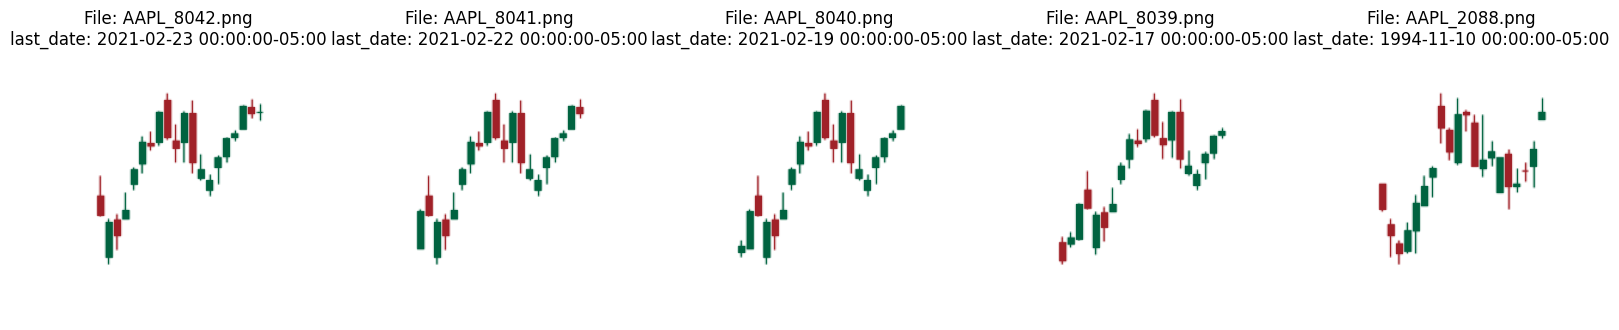

In [61]:
# 유사한 이미지 찾기 (앞서 정의된 함수 사용)
similar_images = find_similar_images(query_img_path, feature_list, image_files, model)

# 라벨 데이터
#labels = [...]  # 이미지 파일 순서와 동일한 라벨 데이터

# 유사한 이미지와 라벨 표시
display_similar_images(similar_images, image_dir, labels, last_dates)


1/1 [==============================] - 0s 13ms/step


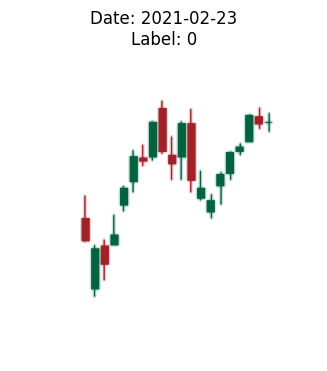

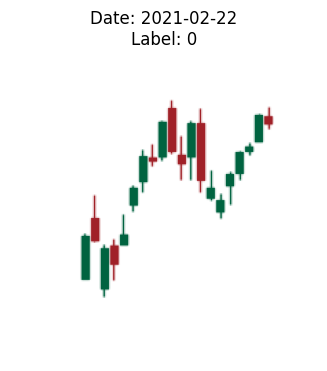

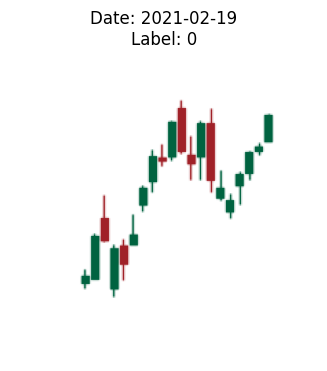

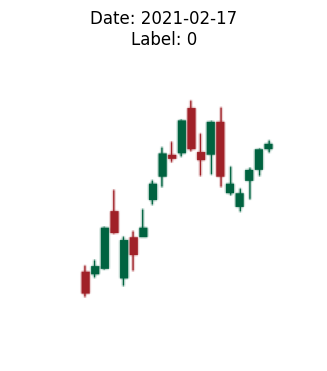

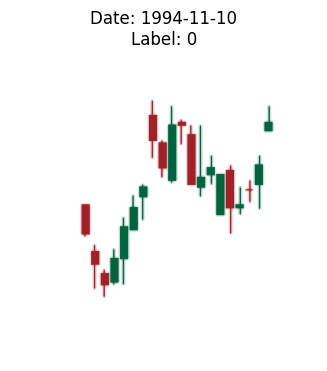

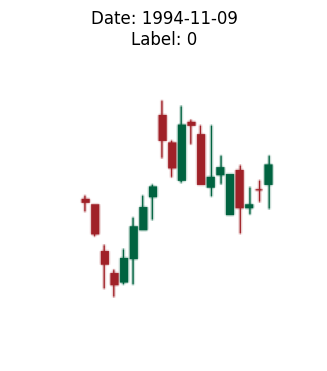

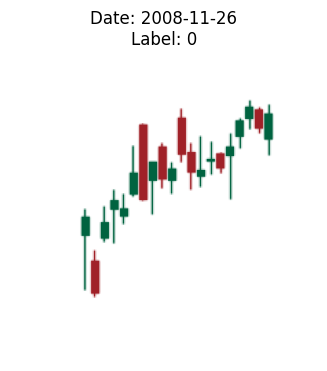

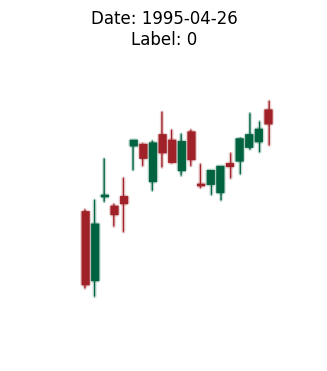

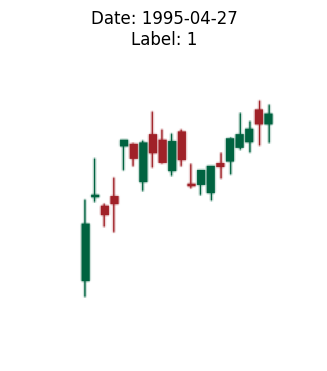

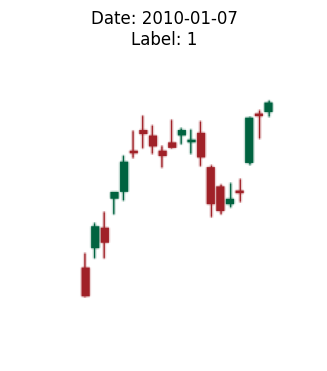

In [62]:
# 쿼리 이미지 경로
query_img_path = 'images/AAPL_8042.png'

# 유사한 이미지 정보 가져오기
similar_images_info = get_similar_images_info(query_img_path, feature_list, image_files, labels, last_dates, model)

for img_info in similar_images_info:
    img_path = os.path.join(image_dir, img_info['filename'])
    image = Image.open(img_path)

    plt.figure(figsize=(8, 4))
    plt.imshow(image)
    plt.title(f"Date: {img_info['last_date'].date()}\nLabel: {img_info['label']}")
    plt.axis('off')
    plt.show()

In [ ]:
# import numpy as np
# from keras.preprocessing.image import load_img, img_to_array

# def create_dataset(image_dir, labels, image_size=IMAGE_SIZE):
#     images = []
#     for i, label in enumerate(labels):
#         image_path = f"{image_dir}/AAPL_{i}.png"  # 이미지 파일 경로
#         image = load_img(image_path, target_size=image_size)  # 이미지 로드
#         image = img_to_array(image)  # 이미지를 배열로 변환
#         images.append((image, label))
    
#     # 이미지와 라벨을 numpy 배열로 변환
#     x = np.array([img for img, lbl in images])
#     y = np.array([lbl for img, lbl in images])
    
#     return x, y



In [ ]:
# image_dir = "images"

# # 데이터셋 생성
# x_train, y_train = create_dataset(image_dir, labels)

In [ ]:
# # 모델 정의
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(이미지_높이, 이미지_너비, 채널)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # 이미지 데이터 로드
# train_generator = load_images(image_dir, image_size, batch_size)

# # 모델 학습
# model.fit(train_generator, epochs=epochs)

# # 모델 저장
# model.save('model.h5')

In [79]:
image_dir = "images"
# 날짜에 해당하는 이미지 파일 찾기
img_index = last_dates.index(query_date)
print(img_index)

query_img_path = os.path.join(image_dir, image_files[img_index])
 

ValueError: '2022-01-12' is not in list

In [80]:
last_dates

[Timestamp('1990-01-29 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-01-30 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-01-31 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-01 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-02 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-05 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-06 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-07 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-08 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-09 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-12 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-13 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-14 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-15 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-16 00:00:00-0500', tz='America/New_York'),
 Timestamp('1990-02-20 00:00:00-0500', tz='America/New_

In [81]:
df.T

Date,1990-01-02 00:00:00-05:00,1990-01-03 00:00:00-05:00,1990-01-04 00:00:00-05:00,1990-01-05 00:00:00-05:00,1990-01-08 00:00:00-05:00,1990-01-09 00:00:00-05:00,1990-01-10 00:00:00-05:00,1990-01-11 00:00:00-05:00,1990-01-12 00:00:00-05:00,1990-01-15 00:00:00-05:00,...,2021-12-16 00:00:00-05:00,2021-12-17 00:00:00-05:00,2021-12-20 00:00:00-05:00,2021-12-21 00:00:00-05:00,2021-12-22 00:00:00-05:00,2021-12-23 00:00:00-05:00,2021-12-27 00:00:00-05:00,2021-12-28 00:00:00-05:00,2021-12-29 00:00:00-05:00,2021-12-30 00:00:00-05:00
Open,0.314732,0.339286,0.341518,0.337054,0.334821,0.339286,0.335938,0.323661,0.305804,0.308036,...,179.279999,169.929993,168.279999,171.559998,173.039993,175.850006,177.089996,180.160004,179.330002,179.470001
High,0.334821,0.339286,0.345982,0.341518,0.339286,0.339286,0.335938,0.323661,0.310268,0.319196,...,181.139999,173.470001,170.580002,173.199997,175.860001,176.850006,180.419998,181.330002,180.630005,180.570007
Low,0.312500,0.334821,0.332589,0.330357,0.330357,0.330357,0.319196,0.308036,0.301339,0.305804,...,170.750000,169.690002,167.460007,169.119995,172.149994,175.270004,177.070007,178.529999,178.139999,178.089996
Close,0.332589,0.334821,0.335938,0.337054,0.339286,0.335938,0.321429,0.308036,0.308036,0.305804,...,172.259995,171.139999,169.750000,172.990005,175.639999,176.279999,180.330002,179.289993,179.380005,178.199997


In [82]:
df.index

DatetimeIndex(['1990-01-02 00:00:00-05:00', '1990-01-03 00:00:00-05:00',
               '1990-01-04 00:00:00-05:00', '1990-01-05 00:00:00-05:00',
               '1990-01-08 00:00:00-05:00', '1990-01-09 00:00:00-05:00',
               '1990-01-10 00:00:00-05:00', '1990-01-11 00:00:00-05:00',
               '1990-01-12 00:00:00-05:00', '1990-01-15 00:00:00-05:00',
               ...
               '2021-12-16 00:00:00-05:00', '2021-12-17 00:00:00-05:00',
               '2021-12-20 00:00:00-05:00', '2021-12-21 00:00:00-05:00',
               '2021-12-22 00:00:00-05:00', '2021-12-23 00:00:00-05:00',
               '2021-12-27 00:00:00-05:00', '2021-12-28 00:00:00-05:00',
               '2021-12-29 00:00:00-05:00', '2021-12-30 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=8063, freq=None)